In [133]:
!unzip 'Sarcasm_Headlines_Dataset.json.zip' -d Sarcasm

Archive:  /content/Sarcasm_Headlines_Dataset.json.zip
replace Sarcasm/Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Sarcasm/Sarcasm_Headlines_Dataset.json  


## Import Libraries

In [134]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [135]:
vocab_size = 10000
embedding_dim = 8
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

## Load the dataset and process it

In [136]:
dataset = []
for file in open('Sarcasm/Sarcasm_Headlines_Dataset.json','r'):
    dataset.append(json.loads(file))

#### to display first 5 element from the given data

In [137]:
def head(data):
    return data[0:5]

In [138]:
head(dataset)

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [139]:
sentences = []
labels = []
urls = []
for data in dataset : 
    sentences.append(data['headline'])
    labels.append(data['is_sarcastic'])
    urls.append(data['article_link'])

In [140]:
head(sentences),head(labels),head(urls)

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild",
  'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'j.k. rowling wishes snape happy birthday in the most magical way'],
 [0, 0, 1, 1, 0],
 ['https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb'])

## Split the Data train, test

In [141]:
len(sentences)

26709

#### build function to handle spliting data

In [142]:
def train_test_split(data,percent):
    split_size = int(len(data) * percent)
    train = data[0:training_size]
    test = data[training_size:]
    return train,test

In [143]:
training_sentences,testing_sentences = train_test_split(sentences,0.8)
training_labels,testing_labels = train_test_split(labels,0.8)

In [181]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#### make the data as array to feed it to neural network

In [187]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Build the model

In [188]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=0.5,
    verbose=1,
    mode='automax',
)

In [229]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [230]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 100, 8)            80000     
                                                                 
 dropout_115 (Dropout)       (None, 100, 8)            0         
                                                                 
 global_average_pooling1d_38  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_116 (Dropout)       (None, 8)                 0         
                                                                 
 dense_148 (Dense)           (None, 8)                 72        
                                                                 
 dropout_117 (Dropout)       (None, 8)                 0         
                                                     

In [231]:
epochs_num = 30

history = model.fit(
    training_padded, training_labels, epochs=epochs_num, 
    validation_data=(testing_padded, testing_labels), verbose=2,
    # callbacks=[callback]
)

Epoch 1/30
625/625 - 3s - loss: 0.6865 - accuracy: 0.5576 - val_loss: 0.6838 - val_accuracy: 0.5633 - 3s/epoch - 4ms/step
Epoch 2/30
625/625 - 2s - loss: 0.6807 - accuracy: 0.5603 - val_loss: 0.6706 - val_accuracy: 0.5633 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 2s - loss: 0.6465 - accuracy: 0.5620 - val_loss: 0.6107 - val_accuracy: 0.7213 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 3s - loss: 0.5845 - accuracy: 0.7226 - val_loss: 0.5307 - val_accuracy: 0.8123 - 3s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.5362 - accuracy: 0.7799 - val_loss: 0.4804 - val_accuracy: 0.8264 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.5050 - accuracy: 0.7920 - val_loss: 0.4674 - val_accuracy: 0.8134 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.4804 - accuracy: 0.7999 - val_loss: 0.4289 - val_accuracy: 0.8390 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.4677 - accuracy: 0.8021 - val_loss: 0.4166 - val_accuracy: 0.8384 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

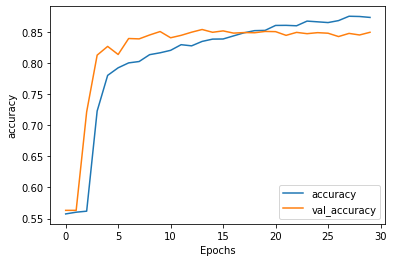

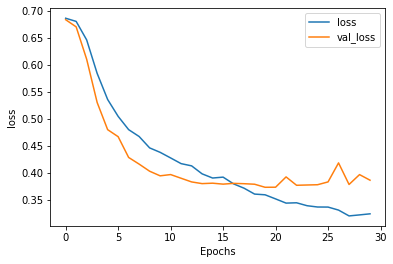

In [232]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Test the model

In [233]:
test_data = [
   'the weather is so moony',
   'the president kill the devil',
   'earthquake in sky!!!'
]

sequences = tokenizer.texts_to_sequences(test_data)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = model.predict(padded)
prediction

array([[0.01070499],
       [0.00922334],
       [0.7490017 ]], dtype=float32)

In [234]:
def label_encoding(pred):
  return ['Real' if p > 0.5 else 'Fake' for p in pred]

In [235]:
print(label_encoding(prediction))

['Fake', 'Fake', 'Real']
